
# AI.3 - Breast Cancer Diagnosis with Multi-Modal Imaging
## Baseline CNN Implementation for Lesion Segmentation
This notebook implements a U-Net based CNN for segmenting breast cancer lesions from multi-modal imaging data (MRI, Ultrasound, Mammography).


### Project Overview:
 - **Objective**: Train a CNN to segment potential cancerous lesions in breast tissue
 - **Architecture**: U-Net with encoder-decoder structure
 - **Dataset**: Kaggle Breast Cancer MSI Multimodal Dataset
 - **Output**: Binary segmentation masks for lesion detection


## Required Python Packages

Install the main dependencies for multi-modal breast cancer classification:

In [1]:
!pip install torch torchvision opencv-python albumentations matplotlib scikit-learn

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

[notice] A new release of pip is available: 25.0.1 -> 25.2
[notice] To update, run: python3 -m pip install --upgrade pip


In [2]:
# Core libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import torchvision.transforms as transforms
from torchvision.transforms import functional as TF
from torchvision.models import resnet50, efficientnet_b0, EfficientNet_B0_Weights


# Data processing
import numpy as np
import pandas as pd
import cv2
import os
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import jaccard_score

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, clear_output
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold
import warnings
warnings.filterwarnings('ignore')

# Augmentation
import albumentations as A
from albumentations.pytorch import ToTensorV2

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("✅ All libraries imported successfully!")
print(f"🔥 PyTorch version: {torch.__version__}")
print(f"🖥️ CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"🎮 GPU: {torch.cuda.get_device_name(0)}")

✅ All libraries imported successfully!
🔥 PyTorch version: 2.1.0+cu118
🖥️ CUDA available: True
🎮 GPU: NVIDIA A30


## Dataset Setup

Copies the KaggleHub breast cancer multi-modal dataset into the project `data/` folder:

In [3]:
import shutil
import os

# Source (where KaggleHub stored the dataset)
src_path = "/home/omniflow/.cache/kagglehub/datasets/zoya77/breast-cancer-msi-multimodal-image-dataset/versions/1"

# Destination (your current project /data folder)
dst_path = os.path.join(os.getcwd(), "data")

# Copy dataset into /data (use move if you don’t want to keep original)
shutil.copytree(src_path, dst_path, dirs_exist_ok=True)

print("Dataset is now available at:", dst_path)

Dataset is now available at: /home/omniflow/test/data


In [4]:
!ls -d /home/omniflow/test/data/*/*/*/

 /home/omniflow/test/data/Chest_XRay_MSI/Test/Malignant/
 /home/omniflow/test/data/Chest_XRay_MSI/Test/Normal/
 /home/omniflow/test/data/Chest_XRay_MSI/Train/Malignant/
 /home/omniflow/test/data/Chest_XRay_MSI/Train/Normal/
 /home/omniflow/test/data/Chest_XRay_MSI/Val/Malignant/
 /home/omniflow/test/data/Chest_XRay_MSI/Val/Normal/
 /home/omniflow/test/data/Histopathological_MSI/Test/benign/
 /home/omniflow/test/data/Histopathological_MSI/Test/malignant/
 /home/omniflow/test/data/Histopathological_MSI/Train/benign/
 /home/omniflow/test/data/Histopathological_MSI/Train/malignant/
 /home/omniflow/test/data/Histopathological_MSI/Val/benign/
 /home/omniflow/test/data/Histopathological_MSI/Val/malignant/
'/home/omniflow/test/data/MultiModel Breast Cancer MSI Dataset/Chest_XRay_MSI/Malignant/'
'/home/omniflow/test/data/MultiModel Breast Cancer MSI Dataset/Chest_XRay_MSI/Normal/'
'/home/omniflow/test/data/MultiModel Breast Cancer MSI Dataset/Histopathological_MSI/benign/'
'/home/omniflow/test/

## Dataset Visualization

Displays sample images from each modality and class to verify data integrity and diversity:

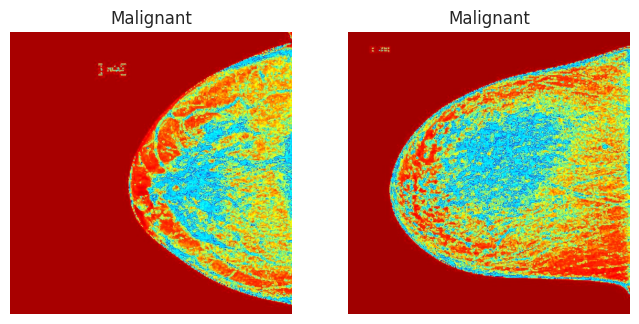

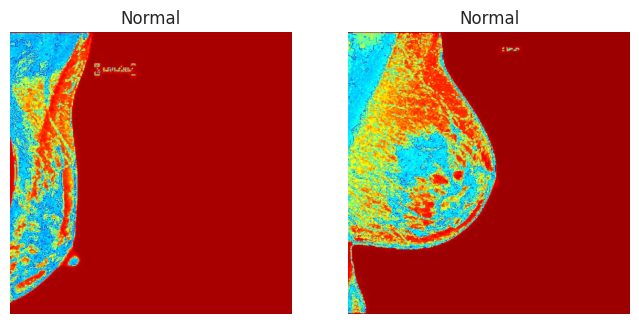

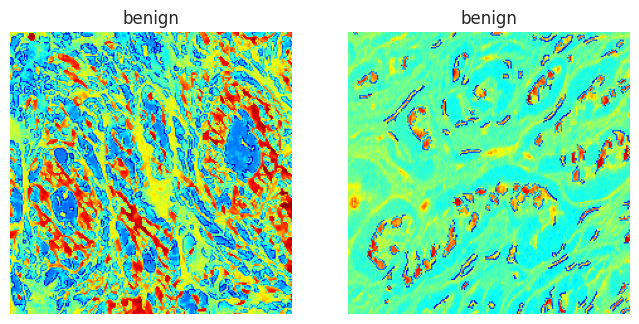

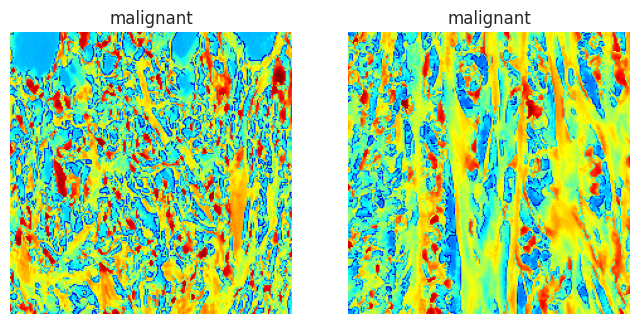

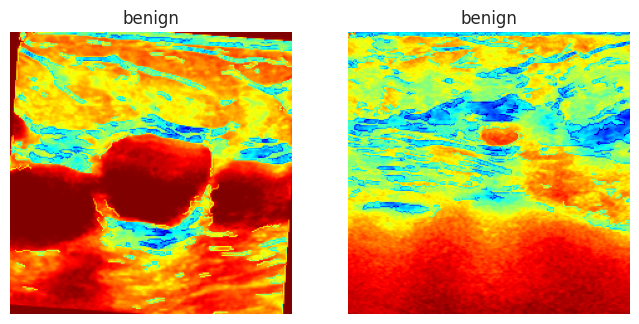

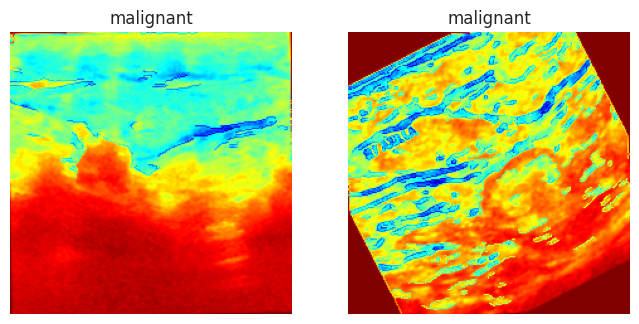

In [5]:
import os
import random
import matplotlib.pyplot as plt
from PIL import Image

# Paths to each modality/class
folders = [
    '/home/omniflow/test/data/MultiModel Breast Cancer MSI Dataset/Chest_XRay_MSI/Malignant/',
    '/home/omniflow/test/data/MultiModel Breast Cancer MSI Dataset/Chest_XRay_MSI/Normal/',
    '/home/omniflow/test/data/MultiModel Breast Cancer MSI Dataset/Histopathological_MSI/benign/',
    '/home/omniflow/test/data/MultiModel Breast Cancer MSI Dataset/Histopathological_MSI/malignant/',
    '/home/omniflow/test/data/MultiModel Breast Cancer MSI Dataset/Ultrasound Images_MSI/benign/',
    '/home/omniflow/test/data/MultiModel Breast Cancer MSI Dataset/Ultrasound Images_MSI/malignant/',
]

# Visualize 2 random images from each folder
for folder in folders:
    label = os.path.basename(folder.rstrip("/"))
    images = [os.path.join(folder, f) for f in os.listdir(folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
    
    if len(images) == 0:
        print(f"No images found in {folder}")
        continue
    
    sample_images = random.sample(images, min(2, len(images)))
    
    plt.figure(figsize=(8, 4))
    for i, img_path in enumerate(sample_images, 1):
        img = Image.open(img_path)
        plt.subplot(1, 2, i)
        plt.imshow(img, cmap='gray')
        plt.title(label)
        plt.axis('off')
    plt.show()

In [6]:
# import os

# def count_images(path):
#     """Recursively count image files in a directory."""
#     image_extensions = ('.png', '.jpg', '.jpeg', '.tif', '.bmp')
#     count = 0
#     for root, _, files in os.walk(path):
#         count += sum(f.lower().endswith(image_extensions) for f in files)
#     return count

# print("📊 Number of images per modality:")

# for modality in config.MODALITIES:
#     train_count = count_images(config.TRAIN_PATHS[modality])
#     val_count = count_images(config.VAL_PATHS[modality])
#     print(f" - {modality.capitalize():15} | Train: {train_count:5} | Val: {val_count:5}")


## Configuration Settings

This section defines the global configuration for training the multimodal deep learning model.  
It centralizes dataset paths, model hyperparameters, and training strategies for easier management.

### Key Components:
- **Data Paths**
  - Supports three modalities: Ultrasound, Histopathology, and Chest X-Ray.
  - Separate directories for training and validation data.

- **Model Parameters**
  - `IMAGE_SIZE = 224`: Standard input size (compatible with transfer learning backbones).
  - `BATCH_SIZE = 16`: Number of samples per training batch.
  - `NUM_EPOCHS = 50`: Maximum number of training iterations.
  - `LEARNING_RATE = 1e-4`: Initial learning rate.
  - `DEVICE`: Automatically selects GPU if available, otherwise falls back to CPU.

- **Advanced Training Parameters**
  - `WEIGHT_DECAY = 1e-4`: Regularization for preventing overfitting.
  - `PATIENCE = 10`: Early stopping patience.
  - `LABEL_SMOOTHING = 0.1`: Stabilizes training by softening labels.
  - `DROPOUT_RATE = 0.3`: Dropout for better generalization.

- **Fusion Strategy**
  - `FUSION_TYPE`: Defines how to combine features from multiple modalities.
    - `"early"`: Feature-level fusion.
    - `"late"`: Decision-level fusion.
    - `"attention"`: Adaptive attention-based fusion.

This setup ensures consistency and flexibility across experiments by allowing quick adjustments in one place.


In [68]:
# Configuration
class Config:
    # Data paths
    MODALITIES = ["Ultrasound Images_MSI", "Histopathological_MSI", "Chest_XRay_MSI"]
    TRAIN_PATHS = {
        "Ultrasound Images_MSI": "data/Ultrasound Images_MSI/Train",
        "Histopathological_MSI": "data/Histopathological_MSI/Train", 
        "Chest_XRay_MSI": "data/Chest_XRay_MSI/Train"
    }
    VAL_PATHS = {
        "Ultrasound Images_MSI": "data/Ultrasound Images_MSI/Val",
        "Histopathological_MSI": "data/Histopathological_MSI/Val",
        "Chest_XRay_MSI": "data/Chest_XRay_MSI/Val"
    }
    
    # Model parameters
    IMAGE_SIZE = 224  # Better for transfer learning
    BATCH_SIZE = 16
    NUM_EPOCHS = 50
    LEARNING_RATE = 1e-4
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Advanced training parameters
    WEIGHT_DECAY = 1e-4
    PATIENCE = 10
    LABEL_SMOOTHING = 0.1
    DROPOUT_RATE = 0.3
    
    # Fusion strategy
    FUSION_TYPE = "attention"  # "early", "late", "attention"
    
config = Config()

## Data Augmentation

Defines preprocessing for training and validation:

- **Train**: resize → random crop → flip → rotate → color jitter → affine transform → tensor → normalize  
- **Val**: resize → tensor → normalize  

Augmentations improve generalization; validation stays deterministic.

In [69]:
# Data Augmentation
class Transforms:
    def __init__(self, image_size=224):
        self.train_transform = transforms.Compose([
            transforms.Resize((image_size + 32, image_size + 32)),
            transforms.RandomCrop(image_size),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomRotation(15),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        
        self.val_transform = transforms.Compose([
            transforms.Resize((image_size, image_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

## Multi-Modal Dataset

Custom PyTorch `Dataset` to load images from multiple modalities.  
Features:
- Supports **Ultrasound, Histopathology, X-Ray** (or any new modality path).  
- Handles **benign/malignant naming variations** with consistent label mapping.  
- Balances class loading and prints dataset stats.  
- Includes error handling for **missing paths, corrupted images, and transform errors**.  

Each sample returns:  
`(image_tensor, label, modality)`

In [70]:
# Multi-Modal Dataset Class 
class MultiModalDataset(Dataset):
    def __init__(self, modality_paths, transform=None, balance_classes=True):
        self.image_paths = []
        self.labels = []
        self.modalities = []
        self.transform = transform
        
        for modality, path in modality_paths.items():
            if not os.path.exists(path):
                print(f"Warning: Path {path} does not exist, skipping {modality}")
                continue
                
            classes = sorted([d for d in os.listdir(path) if os.path.isdir(os.path.join(path, d))])
            
            # Handle different naming conventions (benign/malignant)
            class_mapping = self._create_class_mapping(classes)
            
            class_counts = {}
            for cls in classes:
                cls_path = os.path.join(path, cls)
                images = [f for f in os.listdir(cls_path) 
                         if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff'))]
                class_counts[cls] = len(images)
                
                for img in images:
                    self.image_paths.append(os.path.join(cls_path, img))
                    self.labels.append(class_mapping[cls])
                    self.modalities.append(modality)
            
            print(f"Loaded {modality}: {class_counts}")
        
        # Convert to numpy for easier manipulation
        self.image_paths = np.array(self.image_paths)
        self.labels = np.array(self.labels)
        self.modalities = np.array(self.modalities)
        
        print(f"Total samples: {len(self.image_paths)}")
        print(f"Class distribution: {np.bincount(self.labels)}")
    
    def _create_class_mapping(self, classes):
        """Create consistent binary mapping regardless of class names"""
        class_mapping = {}
        
        # Handle different naming conventions
        benign_names = ['benign', 'normal', 'Normal', 'Benign']
        malignant_names = ['malignant', 'Malignant', 'cancer', 'Cancer']
        
        for cls in classes:
            if cls in benign_names:
                class_mapping[cls] = 0  # Benign
            elif cls in malignant_names:
                class_mapping[cls] = 1  # Malignant
            else:
                # Default mapping based on alphabetical order
                class_mapping[cls] = classes.index(cls) % 2
        
        return class_mapping
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]
        modality = self.modalities[idx]
        
        # Load and preprocess image with better error handling
        try:
            image = Image.open(image_path).convert('RGB')
            # Ensure image is not corrupted
            image.verify()
            image = Image.open(image_path).convert('RGB')  # Reopen after verify
        except Exception as e:
            print(f"Error loading {image_path}: {e}")
            # Return a black image as fallback
            image = Image.new('RGB', (224, 224), (0, 0, 0))
        
        if self.transform:
            try:
                image = self.transform(image)
            except Exception as e:
                print(f"Error transforming image {image_path}: {e}")
                # Create a default tensor
                image = torch.zeros(3, 224, 224)
                
        return image, label, modality


## Attention Module – Channel Attention

Implements a **channel attention mechanism** to enhance important feature maps.  

- Uses **average & max pooling** to capture global context.  
- Shared **MLP (Conv → ReLU → Conv)** reduces & restores channel dimensions.  
- Outputs a **sigmoid attention map** to reweight feature channels.  

In [71]:
# Attention Module
class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        
        self.fc = nn.Sequential(
            nn.Conv2d(in_channels, in_channels // reduction, 1, bias=False),
            nn.ReLU(),
            nn.Conv2d(in_channels // reduction, in_channels, 1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        avg_out = self.fc(self.avg_pool(x))
        max_out = self.fc(self.max_pool(x))
        out = avg_out + max_out
        return self.sigmoid(out)

## Attention Module – Spatial Attention

Applies attention across **spatial dimensions** to highlight key regions.  

- Computes **average & max pooling** along channels.  
- Concatenates them → 2D conv → sigmoid map.  
- Reweights features at each spatial location.  

In [72]:
class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv(x)
        return self.sigmoid(x)

## CBAM (Convolutional Block Attention Module)

Combines **Channel Attention** and **Spatial Attention** sequentially:  

1. Channel attention reweights feature maps.  
2. Spatial attention highlights important regions.  
3. Final output = input × both attention maps.  

This helps the network focus on the most informative features.  

In [73]:
class CBAM(nn.Module):
    def __init__(self, in_channels, reduction=16, kernel_size=7):
        super(CBAM, self).__init__()
        self.channel_attention = ChannelAttention(in_channels, reduction)
        self.spatial_attention = SpatialAttention(kernel_size)
    
    def forward(self, x):
        x = x * self.channel_attention(x)
        x = x * self.spatial_attention(x)
        return x

## Enhanced CNN with Attention

CNN classifier with two backbone options:  

- **ResNet-50 (pretrained)**: replaces FC with identity, feature dim = 2048.  
- **Custom CNN + CBAM**: stacked conv → BN → ReLU → CBAM → pooling, feature dim = 512.  

**Classifier head**:  
- Dropout + Linear layers with BN & ReLU.  
- Progressive reduction (2048/512 → 512 → 256 → `num_classes`).  

Adds **attention (CBAM)** and strong **regularization** for better generalization.  

In [74]:
# Enhanced CNN Architecture with Attention
class EnhancedCNN(nn.Module):
    def __init__(self, num_classes=2, dropout_rate=0.3, use_pretrained=True):
        super(EnhancedCNN, self).__init__()
        
        # Use resnet50 as backbone with fixed weights parameter
        if use_pretrained:
                self.backbone = resnet50(weights='IMAGENET1K_V1')
                self.backbone.fc = nn.Identity()
                feature_dim = 2048
        else:
            # Custom backbone with attention
            self.backbone = nn.Sequential(
                nn.Conv2d(3, 64, 3, padding=1),
                nn.BatchNorm2d(64),
                nn.ReLU(),
                CBAM(64),
                nn.MaxPool2d(2),
                
                nn.Conv2d(64, 128, 3, padding=1),
                nn.BatchNorm2d(128),
                nn.ReLU(),
                CBAM(128),
                nn.MaxPool2d(2),
                
                nn.Conv2d(128, 256, 3, padding=1),
                nn.BatchNorm2d(256),
                nn.ReLU(),
                CBAM(256),
                nn.MaxPool2d(2),
                
                nn.Conv2d(256, 512, 3, padding=1),
                nn.BatchNorm2d(512),
                nn.ReLU(),
                CBAM(512),
                nn.AdaptiveAvgPool2d(1)
            )
            feature_dim = 512
        
        # Classifier head with better regularization
        self.classifier = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(feature_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout_rate * 0.5),
            nn.Linear(256, num_classes)
        )
        
    def forward(self, x):
        features = self.backbone(x)
        if len(features.shape) > 2:
            features = F.adaptive_avg_pool2d(features, (1, 1)).flatten(1)
        return self.classifier(features)

## Multi-Modal Fusion Network

Architecture for combining **Ultrasound, Histopathology, and X-Ray** inputs.  
Each modality uses an **EnhancedCNN** encoder with separate weights.  

Fusion strategies:  
- **Late fusion** → concatenate predictions → MLP classifier.  
- **Attention fusion** → learnable weights & softmax over modalities.  
- **Average fusion** → simple mean of outputs.  

Enables flexible multi-modal learning with improved generalization.  

In [75]:
# Multi-Modal Fusion Network with improved architecture
class MultiModalFusionNet(nn.Module):
    def __init__(self, num_classes=2, fusion_type="late", dropout_rate=0.3):
        super(MultiModalFusionNet, self).__init__()
        self.fusion_type = fusion_type
        
        # Individual modality encoders with shared architecture but separate weights
        self.ultrasound_encoder = EnhancedCNN(num_classes, dropout_rate)
        self.histopath_encoder = EnhancedCNN(num_classes, dropout_rate)
        self.xray_encoder = EnhancedCNN(num_classes, dropout_rate)
        
        if fusion_type == "late":
            # Late fusion: combine predictions
            self.fusion_layer = nn.Sequential(
                nn.Linear(num_classes * 3, 128),
                nn.BatchNorm1d(128),
                nn.ReLU(),
                nn.Dropout(dropout_rate),
                nn.Linear(128, 64),
                nn.BatchNorm1d(64),
                nn.ReLU(),
                nn.Dropout(dropout_rate * 0.5),
                nn.Linear(64, num_classes)
            )
        elif fusion_type == "attention":
            # Attention-based fusion with learnable weights
            self.attention_weights = nn.Parameter(torch.ones(3) / 3)
            self.attention_transform = nn.Sequential(
                nn.Linear(num_classes * 3, 64),
                nn.ReLU(),
                nn.Linear(64, 3),
                nn.Softmax(dim=1)
            )
            
    def forward(self, x, modality_info=None):
        # x: batch of images
        # modality_info: tensor indicating modality for each sample
        
        batch_size = x.size(0)
        
        # Get features from all encoders
        us_out = self.ultrasound_encoder(x)
        hist_out = self.histopath_encoder(x)
        xray_out = self.xray_encoder(x)
        
        if self.fusion_type == "late":
            # Concatenate all outputs
            combined = torch.cat([us_out, hist_out, xray_out], dim=1)
            return self.fusion_layer(combined)
        elif self.fusion_type == "attention":
            # Dynamic attention based on input features
            combined_features = torch.cat([us_out, hist_out, xray_out], dim=1)
            attention_weights = self.attention_transform(combined_features)
            
            # Apply attention weights
            weighted_us = attention_weights[:, 0:1] * us_out
            weighted_hist = attention_weights[:, 1:2] * hist_out
            weighted_xray = attention_weights[:, 2:3] * xray_out
            
            return weighted_us + weighted_hist + weighted_xray
        else:
            # Simple average
            return (us_out + hist_out + xray_out) / 3

## Training Loop

Trainer class with modern training features:  

- **Loss**: Cross-entropy with label smoothing.  
- **Optimizer**: AdamW with weight decay & gradient clipping.  
- **Scheduler**: OneCycleLR warmup + dynamic LR updates.  
- **Metrics**: tracks loss, accuracy, and AUC.  
- **Regularization**: early stopping & best-model checkpointing.  
- **Visualization**: plots training/validation curves, AUC, and LR schedule.  

Supports stable and efficient training for multimodal deep learning models.  


In [76]:
# Enhanced Training Loop with Advanced Features
class AdvancedTrainer:
    def __init__(self, model, config, results_dir="results"):
        self.model = model
        self.config = config
        self.device = config.DEVICE
        self.results_dir = results_dir
        os.makedirs(self.results_dir, exist_ok=True)  # Ensure folder exists
        
        # Loss function with label smoothing and class weighting
        self.criterion = nn.CrossEntropyLoss(label_smoothing=config.LABEL_SMOOTHING)
        
        # Optimizer with weight decay
        self.optimizer = optim.AdamW(
            model.parameters(), 
            lr=config.LEARNING_RATE, 
            weight_decay=config.WEIGHT_DECAY,
            eps=1e-8
        )
        
        # Learning rate scheduler with warmup
        self.scheduler = optim.lr_scheduler.OneCycleLR(
            self.optimizer, 
            max_lr=config.LEARNING_RATE * 10,
            steps_per_epoch=1,  # Updated later in train()
            epochs=config.NUM_EPOCHS,
            pct_start=0.1
        )
        
        # Training history
        self.history = {
            'train_loss': [], 'train_acc': [],
            'val_loss': [], 'val_acc': [],
            'val_auc': [], 'learning_rates': []
        }
        
        # Best model tracking
        self.best_val_auc = 0.0
        self.best_model_state = None
        
    def train_epoch(self, train_loader):
        self.model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for batch_idx, (images, labels, modalities) in enumerate(train_loader):
            images, labels = images.to(self.device), labels.to(self.device)
            
            self.optimizer.zero_grad()
            outputs = self.model(images)
            loss = self.criterion(outputs, labels)
            
            # Gradient clipping for stability
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=1.0)
            
            loss.backward()
            self.optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Progress tracking
            if batch_idx % 50 == 0:
                print(f'Batch [{batch_idx}/{len(train_loader)}], Loss: {loss.item():.4f}')
        
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = correct / total
        return epoch_loss, epoch_acc
    
    def validate_epoch(self, val_loader):
        self.model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        all_probs = []
        all_labels = []
        
        with torch.no_grad():
            for images, labels, modalities in val_loader:
                images, labels = images.to(self.device), labels.to(self.device)
                
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)
                
                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
                # Store probabilities for AUC calculation
                probs = F.softmax(outputs, dim=1)[:, 1]  # Probability of positive class
                all_probs.extend(probs.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        epoch_loss = running_loss / len(val_loader)
        epoch_acc = correct / total
        
        # Calculate AUC
        try:
            if len(np.unique(all_labels)) > 1:
                auc_score = roc_auc_score(all_labels, all_probs)
            else:
                auc_score = 0.5
        except Exception as e:
            print(f"Error calculating AUC: {e}")
            auc_score = 0.5
            
        return epoch_loss, epoch_acc, auc_score, all_labels, all_probs
    
    def train(self, train_loader, val_loader, num_epochs):
        # Update scheduler steps per epoch
        self.scheduler = optim.lr_scheduler.OneCycleLR(
            self.optimizer, 
            max_lr=self.config.LEARNING_RATE * 10,
            steps_per_epoch=len(train_loader),
            epochs=num_epochs,
            pct_start=0.1
        )
        
        best_val_loss = float('inf')
        patience_counter = 0
        
        for epoch in range(num_epochs):
            print(f'\nEpoch [{epoch+1}/{num_epochs}]')
            print('-' * 50)
            
            # Training
            train_loss, train_acc = self.train_epoch(train_loader)
            
            # Validation
            val_loss, val_acc, val_auc, val_labels, val_probs = self.validate_epoch(val_loader)
            
            # Update learning rate after each epoch
            if hasattr(self.scheduler, 'step'):
                if isinstance(self.scheduler, optim.lr_scheduler.OneCycleLR):
                    pass  # OneCycleLR is updated in train_epoch
                else:
                    self.scheduler.step(val_loss)
            
            # Store history
            current_lr = self.optimizer.param_groups[0]['lr']
            self.history['train_loss'].append(train_loss)
            self.history['train_acc'].append(train_acc)
            self.history['val_loss'].append(val_loss)
            self.history['val_acc'].append(val_acc)
            self.history['val_auc'].append(val_auc)
            self.history['learning_rates'].append(current_lr)
            
            print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
            print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val AUC: {val_auc:.4f}')
            print(f'LR: {current_lr:.2e}')
            
            # Save best model based on AUC
            if val_auc > self.best_val_auc:
                self.best_val_auc = val_auc
                self.best_model_state = self.model.state_dict().copy()
                torch.save(self.best_model_state, 'best_multimodal_model.pth')
                print(f'New best model saved with AUC: {val_auc:.4f}')
                patience_counter = 0
            else:
                patience_counter += 1
                
            # Early stopping based on validation loss
            if val_loss < best_val_loss:
                best_val_loss = val_loss
            else:
                if patience_counter >= self.config.PATIENCE:
                    print(f'Early stopping at epoch {epoch+1}')
                    break
        
        # Load best model
        if self.best_model_state is not None:
            self.model.load_state_dict(self.best_model_state)
            print(f'Loaded best model with AUC: {self.best_val_auc:.4f}')
    
    def plot_history(self, save_path=None):
            """Plots training history and saves the figure to results folder."""
            fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))
            
            # Loss
            ax1.plot(self.history['train_loss'], label='Train Loss', color='blue')
            ax1.plot(self.history['val_loss'], label='Val Loss', color='red')
            ax1.set_title('Model Loss')
            ax1.set_xlabel('Epoch')
            ax1.set_ylabel('Loss')
            ax1.legend()
            ax1.grid(True, alpha=0.3)
            
            # Accuracy
            ax2.plot(self.history['train_acc'], label='Train Acc', color='blue')
            ax2.plot(self.history['val_acc'], label='Val Acc', color='red')
            ax2.set_title('Model Accuracy')
            ax2.set_xlabel('Epoch')
            ax2.set_ylabel('Accuracy')
            ax2.legend()
            ax2.grid(True, alpha=0.3)
            
            # AUC
            ax3.plot(self.history['val_auc'], label='Val AUC', color='green', linewidth=2)
            ax3.axhline(y=self.best_val_auc, color='red', linestyle='--', 
                        label=f'Best AUC: {self.best_val_auc:.3f}')
            ax3.set_title('Validation AUC')
            ax3.set_xlabel('Epoch')
            ax3.set_ylabel('AUC Score')
            ax3.legend()
            ax3.grid(True, alpha=0.3)
            
            # Learning Rate
            ax4.plot(self.history['learning_rates'], label='Learning Rate', color='orange')
            ax4.set_title('Learning Rate Schedule')
            ax4.set_xlabel('Epoch')
            ax4.set_ylabel('Learning Rate')
            ax4.set_yscale('log')
            ax4.legend()
            ax4.grid(True, alpha=0.3)
            
            plt.tight_layout()
            
            # Save figure
            if save_path is None:
                save_path = os.path.join(self.results_dir, "training_history.png")
            plt.savefig(save_path, dpi=300)
            print(f"Training history plot saved to: {save_path}")
            plt.tight_layout()
            plt.show()
            plt.close(fig)

## Model Evaluation

Evaluator for comprehensive testing of multimodal models:  

- Computes **predictions, probabilities, and modalities** for the test set.  
- Generates **plots**:
  - Confusion Matrix  
  - ROC Curve with AUC  
  - Prediction probability distributions  
  - Classification report with **accuracy, sensitivity, specificity, precision, recall**  
- Returns key metrics for further analysis.  

Supports detailed evaluation of both overall and per-modality performance.

In [77]:
class ModelEvaluator:
    def __init__(self, model, device, results_dir="results"):
        self.model = model
        self.device = device
        self.results_dir = results_dir
        os.makedirs(self.results_dir, exist_ok=True)  # Ensure folder exists

    def evaluate(self, test_loader, return_per_modality=False):
        self.model.eval()
        all_preds = []
        all_labels = []
        all_probs = []
        all_modalities = []
        
        with torch.no_grad():
            for images, labels, modalities in test_loader:
                images = images.to(self.device)
                outputs = self.model(images)
                
                probs = F.softmax(outputs, dim=1)
                _, predicted = torch.max(outputs, 1)
                
                all_probs.extend(probs[:, 1].cpu().numpy())
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.numpy())
                all_modalities.extend(modalities)
        
        results = {
            'labels': np.array(all_labels),
            'predictions': np.array(all_preds),
            'probabilities': np.array(all_probs),
            'modalities': np.array(all_modalities)
        }
        
        return results
    
    def plot_comprehensive_results(self, results, save_path=None):
        y_true = results['labels']
        y_pred = results['predictions']
        y_probs = results['probabilities']
        
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))
        
        # Confusion Matrix
        cm = confusion_matrix(y_true, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                   xticklabels=['Benign', 'Malignant'], 
                   yticklabels=['Benign', 'Malignant'], ax=ax1)
        ax1.set_title('Confusion Matrix')
        ax1.set_xlabel('Predicted')
        ax1.set_ylabel('Actual')
        
        # ROC Curve
        fpr, tpr, _ = roc_curve(y_true, y_probs)
        auc_score = roc_auc_score(y_true, y_probs)
        ax2.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.3f})', linewidth=2)
        ax2.plot([0, 1], [0, 1], 'k--', label='Random', alpha=0.5)
        ax2.set_xlabel('False Positive Rate')
        ax2.set_ylabel('True Positive Rate')
        ax2.set_title('ROC Curve')
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        # Prediction Distribution
        ax3.hist(y_probs[y_true == 0], alpha=0.7, label='Benign', bins=20, color='blue')
        ax3.hist(y_probs[y_true == 1], alpha=0.7, label='Malignant', bins=20, color='red')
        ax3.axvline(0.5, color='black', linestyle='--', alpha=0.5, label='Threshold')
        ax3.set_xlabel('Prediction Probability')
        ax3.set_ylabel('Count')
        ax3.set_title('Prediction Distribution')
        ax3.legend()
        ax3.grid(True, alpha=0.3)
        
        # Classification Report as formatted text
        report = classification_report(y_true, y_pred, 
                                     target_names=['Benign', 'Malignant'], 
                                     output_dict=True)
        ax4.axis('off')
        
        # Additional metrics
        tn, fp, fn, tp = cm.ravel()
        sensitivity = tp / (tp + fn)
        specificity = tn / (tn + fp)
        
        report_text = f"""
                        Classification Report:
                        
                        Benign (Class 0):
                          Precision: {report['Benign']['precision']:.3f}
                          Recall: {report['Benign']['recall']:.3f}
                          F1-score: {report['Benign']['f1-score']:.3f}
                        
                        Malignant (Class 1):
                          Precision: {report['Malignant']['precision']:.3f}
                          Recall: {report['Malignant']['recall']:.3f}
                          F1-score: {report['Malignant']['f1-score']:.3f}
                        
                        Overall Metrics:
                          Accuracy: {report['accuracy']:.3f}
                          AUC Score: {auc_score:.3f}
                          Sensitivity: {sensitivity:.3f}
                          Specificity: {specificity:.3f}
                          
                        Support:
                          Benign: {report['Benign']['support']:.0f}
                          Malignant: {report['Malignant']['support']:.0f}
        """
        ax4.text(0.1, 0.5, report_text, fontsize=11, verticalalignment='center',
                 fontfamily='monospace')
        
        plt.tight_layout()
        
        # Save figure
        if save_path is None:
            save_path = os.path.join(self.results_dir, "evaluation_results.png")
        plt.savefig(save_path, dpi=300)
        print(f"Comprehensive evaluation plot saved to: {save_path}")
        plt.show()
        plt.close(fig)
        
        return {
            'auc': auc_score,
            'sensitivity': sensitivity,
            'specificity': specificity,
            'accuracy': report['accuracy'],
            'precision_malignant': report['Malignant']['precision'],
            'recall_malignant': report['Malignant']['recall']
        }

## Main Training Script

Orchestrates the full multi-modal breast cancer classification pipeline:  

- **Setup**: device, PyTorch version, error handling.  
- **Data**: initializes transforms, datasets, and DataLoaders with validation.  
- **Model**: initializes `EnhancedCNN` or `MultiModalFusionNet`, with fallback for errors.  
- **Training**: uses `AdvancedTrainer` with early stopping, LR scheduling, and checkpointing.  
- **Evaluation**: runs `ModelEvaluator` to calculate metrics, plot results, and print a comprehensive report.  
- **Saving**: final model, configuration, metrics, and training history are saved.  

Includes robust **error handling** for missing data, model initialization issues, and training failures.

In [78]:
import os
import torch
from torch.utils.data import DataLoader
# import your other modules like Transforms, MultiModalDataset, EnhancedCNN, MultiModalFusionNet, AdvancedTrainer, ModelEvaluator, config

# Ensure results directory exists
RESULTS_DIR = "results"
os.makedirs(RESULTS_DIR, exist_ok=True)

# Main Training Script with error handling
def main():
    print("Starting Enhanced Multi-Modal Breast Cancer Classification...")
    print(f"Using device: {config.DEVICE}")
    print(f"PyTorch version: {torch.__version__}")
    
    try:
        # Initialize transforms
        transforms_obj = Transforms(config.IMAGE_SIZE)
        
        # Create datasets
        print("\nLoading datasets...")
        train_dataset = MultiModalDataset(
            config.TRAIN_PATHS, 
            transform=transforms_obj.train_transform
        )
        val_dataset = MultiModalDataset(
            config.VAL_PATHS, 
            transform=transforms_obj.val_transform
        )
        
        if len(train_dataset) == 0 or len(val_dataset) == 0:
            raise ValueError("No data found in the specified paths. Please check your data directories.")
        
        # Create data loaders
        train_loader = DataLoader(
            train_dataset, 
            batch_size=config.BATCH_SIZE, 
            shuffle=True, 
            num_workers=min(4, os.cpu_count() or 1),
            pin_memory=torch.cuda.is_available(),
            drop_last=True
        )
        val_loader = DataLoader(
            val_dataset, 
            batch_size=config.BATCH_SIZE, 
            shuffle=False, 
            num_workers=min(4, os.cpu_count() or 1),
            pin_memory=torch.cuda.is_available()
        )
        
        print(f"Training batches: {len(train_loader)}")
        print(f"Validation batches: {len(val_loader)}")
        
        # Initialize model
        print("\nInitializing model...")
        try:
            if config.FUSION_TYPE == "single":
                model = EnhancedCNN(num_classes=2, dropout_rate=config.DROPOUT_RATE)
            else:
                model = MultiModalFusionNet(
                    num_classes=2, 
                    fusion_type=config.FUSION_TYPE, 
                    dropout_rate=config.DROPOUT_RATE
                )
            model = model.to(config.DEVICE)
            
            # Print model info
            total_params = sum(p.numel() for p in model.parameters())
            trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
            print(f"Total parameters: {total_params:,}")
            print(f"Trainable parameters: {trainable_params:,}")
            
        except Exception as e:
            print(f"Error initializing model: {e}")
            print("Falling back to simple CNN...")
            model = EnhancedCNN(num_classes=2, dropout_rate=config.DROPOUT_RATE, use_pretrained=False)
            model = model.to(config.DEVICE)
        
        # Initialize trainer
        print("\nInitializing trainer...")
        trainer = AdvancedTrainer(model, config, results_dir=RESULTS_DIR) 
        
        # Train model
        print("\nStarting training...")
        print("=" * 60)
        trainer.train(train_loader, val_loader, config.NUM_EPOCHS)
        
        # Plot training history and save to results folder
        print("\nPlotting training history...")
        history_plot_path = os.path.join(RESULTS_DIR, "training_history.png")
        trainer.plot_history(save_path=history_plot_path)
        
        # Evaluate model
        print("\nEvaluating model on validation set...")
        evaluator = ModelEvaluator(model, config.DEVICE, results_dir=RESULTS_DIR)
        # Save the evaluation plot inside results folder
        results = evaluator.evaluate(val_loader)
        save_path = os.path.join(RESULTS_DIR, "evaluation_results.png")
        metrics = evaluator.plot_comprehensive_results(results, save_path=save_path)
        
        # Print final metrics
        print("\nFinal Evaluation Metrics:")
        print("=" * 40)
        for metric, value in metrics.items():
            print(f"{metric.capitalize().replace('_', ' ')}: {value:.4f}")
        
        # Save final model to results folder
        final_model_path = os.path.join(RESULTS_DIR, 'final_multimodal_model.pth')
        print(f"\nSaving final model to {final_model_path} ...")
        torch.save({
            'model_state_dict': model.state_dict(),
            'config': config,
            'metrics': metrics,
            'history': trainer.history
        }, final_model_path)
        
        print("\nTraining completed successfully!")
        return model, trainer, evaluator, metrics
        
    except Exception as e:
        print(f"\nError during training: {e}")
        import traceback
        traceback.print_exc()
        return None, None, None, None

### Main Script
- Runs **full training pipeline**: transforms → dataset → model → trainer → evaluation → save.  

Starting Enhanced Multi-Modal Breast Cancer Classification...
Using device: cuda
PyTorch version: 2.1.0+cu118

Loading datasets...
Loaded Ultrasound Images_MSI: {'benign': 326, 'malignant': 320}
Loaded Histopathological_MSI: {'benign': 499, 'malignant': 499}
Loaded Chest_XRay_MSI: {'Malignant': 400, 'Normal': 400}
Total samples: 2444
Class distribution: [1225 1219]
Loaded Ultrasound Images_MSI: {'benign': 40, 'malignant': 40}
Loaded Histopathological_MSI: {'benign': 62, 'malignant': 62}
Loaded Chest_XRay_MSI: {'Malignant': 50, 'Normal': 50}
Total samples: 304
Class distribution: [152 152]
Training batches: 152
Validation batches: 19

Initializing model...
Total parameters: 74,072,140
Trainable parameters: 74,072,140

Initializing trainer...

Starting training...

Epoch [1/50]
--------------------------------------------------
Batch [0/152], Loss: 0.7263
Batch [50/152], Loss: 0.7732
Batch [100/152], Loss: 0.6843
Batch [150/152], Loss: 0.4995
Train Loss: 0.6442, Train Acc: 0.6229
Val Los

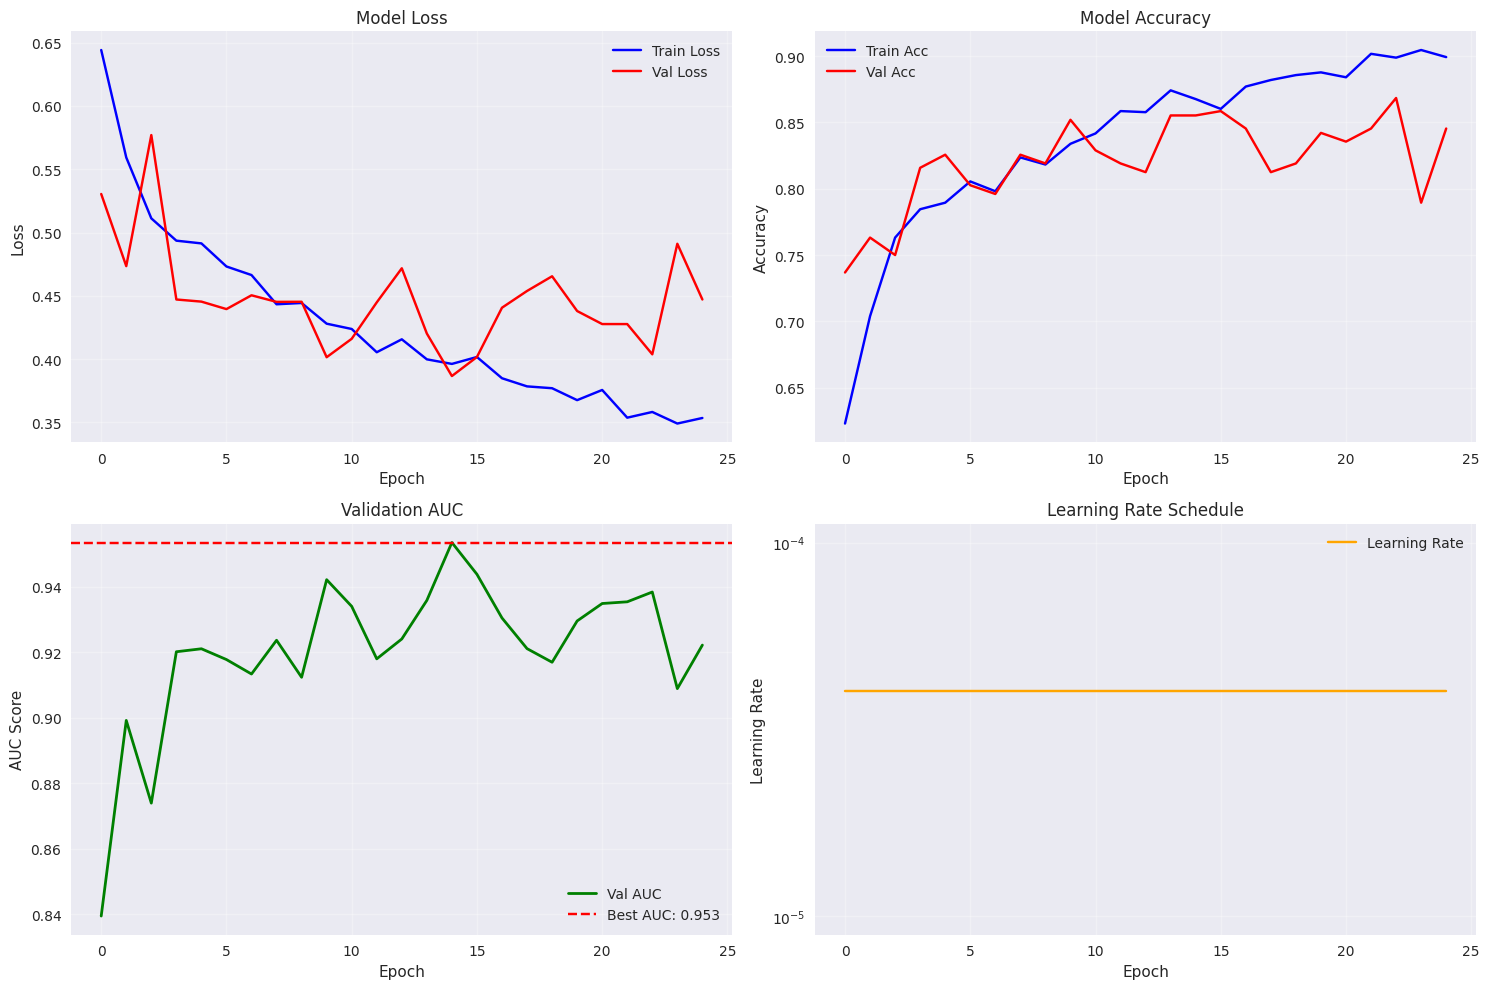


Evaluating model on validation set...
Comprehensive evaluation plot saved to: results/evaluation_results.png


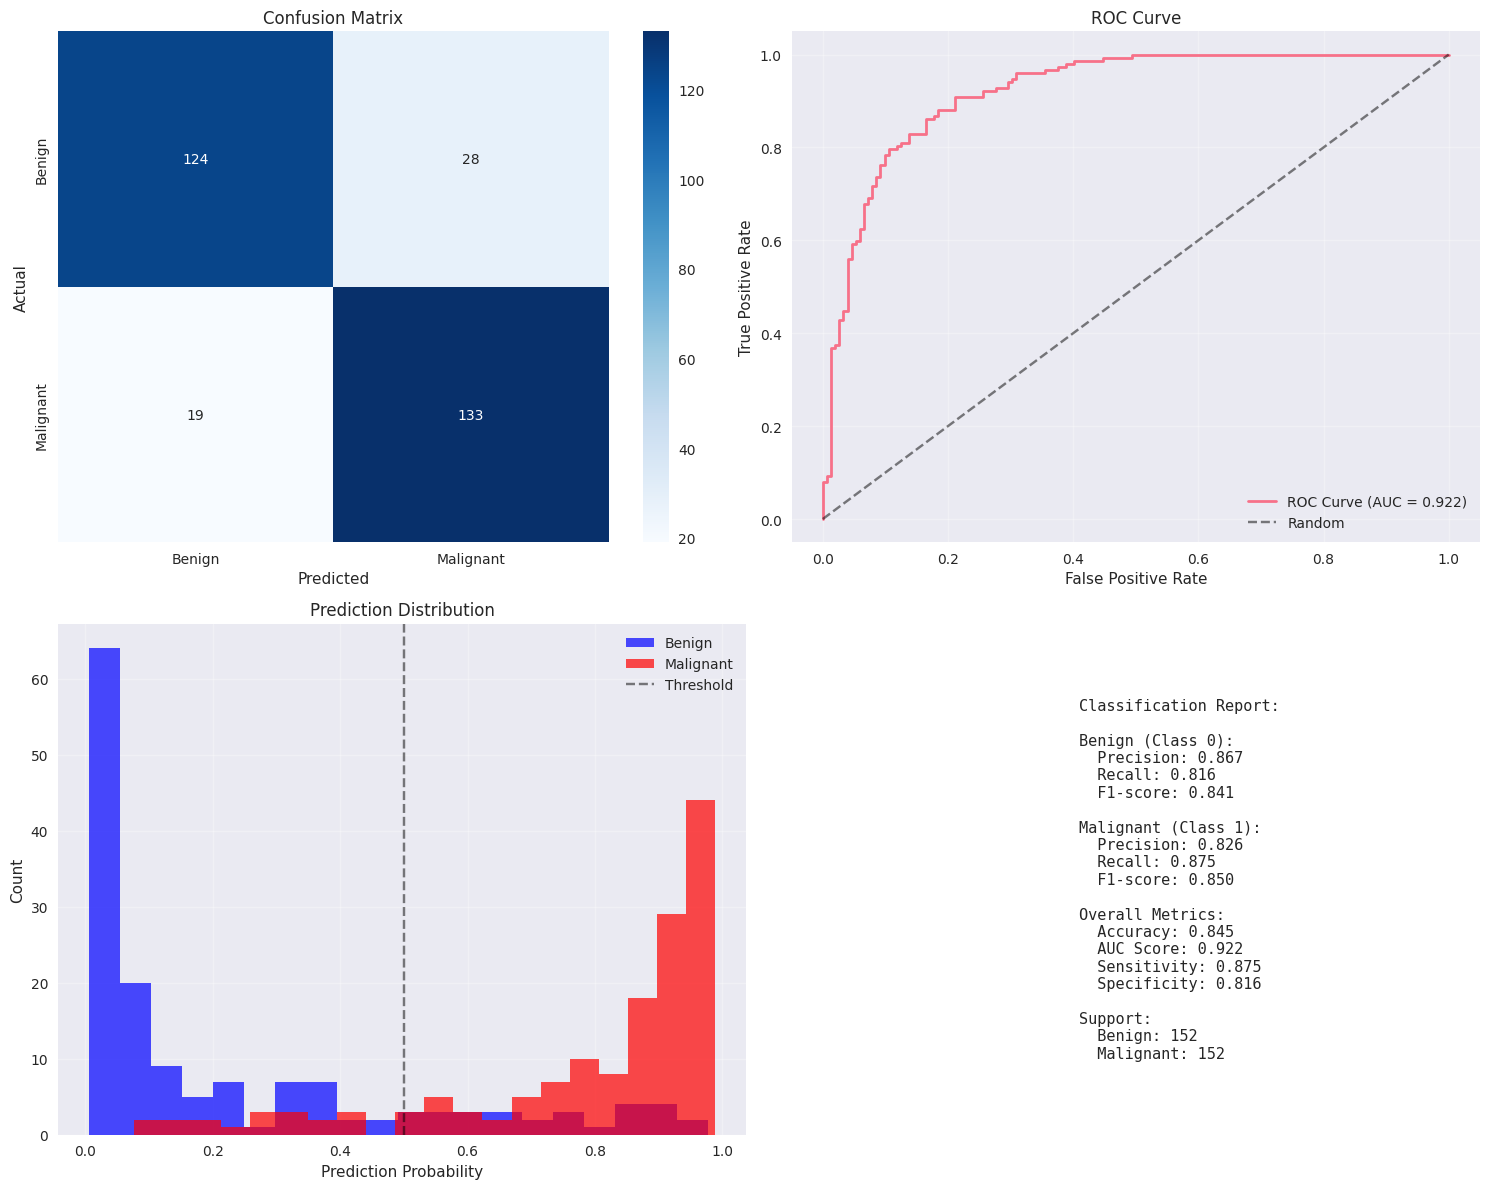


Final Evaluation Metrics:
Auc: 0.9221
Sensitivity: 0.8750
Specificity: 0.8158
Accuracy: 0.8454
Precision malignant: 0.8261
Recall malignant: 0.8750

Saving final model to results/final_multimodal_model.pth ...

Training completed successfully!


In [79]:
# Run main training
model, trainer, evaluator, metrics = main()

### Utilities
- **`analyze_model_predictions`** → visualizes model predictions with confidence, true labels, and modality.  
- **`load_and_evaluate_saved_model`** → loads a checkpoint and evaluates metrics/plots results.  
- **`cross_validation_evaluation`** → performs k-fold CV with training, evaluation, and metric summaries.  
- **`analyze_dataset_distribution`** → prints class and modality distributions, including cross-tabulation.  



In [80]:
RESULTS_DIR = "results"
os.makedirs(RESULTS_DIR, exist_ok=True)

def analyze_model_predictions(model, data_loader, device, num_samples=10, save_path=None):
    """Analyze model predictions on sample images and save the figure."""
    model.eval()
    samples_shown = 0
    
    fig = plt.figure(figsize=(20, 4 * ((num_samples + 4) // 5)))
    
    with torch.no_grad():
        for batch_idx, (images, labels, modalities) in enumerate(data_loader):
            if samples_shown >= num_samples:
                break
                
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = F.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)
            
            for i in range(min(len(images), num_samples - samples_shown)):
                plt.subplot((num_samples + 4) // 5, 5, samples_shown + 1)
                
                # Denormalize image for display
                img = images[i].cpu()
                mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
                std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
                img = img * std + mean
                img = torch.clamp(img, 0, 1)
                
                plt.imshow(img.permute(1, 2, 0))
                
                true_label = "Malignant" if labels[i].item() == 1 else "Benign"
                pred_label = "Malignant" if predicted[i].item() == 1 else "Benign"
                confidence = probs[i].max().item()
                modality = modalities[i]
                
                color = 'green' if predicted[i] == labels[i] else 'red'
                plt.title(f'True: {true_label}\nPred: {pred_label}\n'
                         f'Conf: {confidence:.2f}\nMod: {modality}', 
                         color=color, fontsize=10)
                plt.axis('off')
                
                samples_shown += 1
                if samples_shown >= num_samples:
                    break
    
    plt.tight_layout()
    if save_path is None:
        save_path = os.path.join(RESULTS_DIR, "sample_predictions.png")
    plt.savefig(save_path, dpi=300)
    print(f"Sample predictions saved to: {save_path}")
    plt.show()
    plt.close(fig)


def load_and_evaluate_saved_model(model_path, test_loader, device, save_dir=RESULTS_DIR):
    """Load a saved model and evaluate it, saving all plots to results."""
    try:
        checkpoint = torch.load(model_path, map_location=device)
        
        model = EnhancedCNN(num_classes=2)
        model.load_state_dict(checkpoint['model_state_dict'] if 'model_state_dict' in checkpoint else checkpoint)
        model = model.to(device)
        
        evaluator = ModelEvaluator(model, device, results_dir=save_dir)
        results = evaluator.evaluate(test_loader)
        metrics = evaluator.plot_comprehensive_results(results, save_dir=save_dir)
        
        print("Saved model evaluation:")
        for metric, value in metrics.items():
            print(f"{metric.capitalize().replace('_', ' ')}: {value:.4f}")
        
        return model, results, metrics
        
    except Exception as e:
        print(f"Error loading saved model: {e}")
        return None, None, None


def cross_validation_evaluation(config, k_folds=5, save_dir=RESULTS_DIR):
    """Perform k-fold cross-validation and save plots/metrics."""
    print(f"Starting {k_folds}-fold cross-validation...")
    
    transforms_obj = Transforms(config.IMAGE_SIZE)
    all_paths = {**config.TRAIN_PATHS, **config.VAL_PATHS}
    full_dataset = MultiModalDataset(all_paths, transform=transforms_obj.val_transform)
    
    skf = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)
    cv_results = []
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(range(len(full_dataset)), full_dataset.labels)):
        print(f"\nFold {fold + 1}/{k_folds}")
        print("-" * 30)
        
        train_subset = torch.utils.data.Subset(full_dataset, train_idx)
        val_subset = torch.utils.data.Subset(full_dataset, val_idx)
        
        train_loader = DataLoader(train_subset, batch_size=config.BATCH_SIZE, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=config.BATCH_SIZE, shuffle=False)
        
        model = EnhancedCNN(num_classes=2, dropout_rate=config.DROPOUT_RATE).to(config.DEVICE)
        trainer = AdvancedTrainer(model, config, results_dir=save_dir)
        
        cv_epochs = min(20, config.NUM_EPOCHS)
        trainer.train(train_loader, val_loader, cv_epochs)
        
        # Save training history for this fold
        fold_history_path = os.path.join(save_dir, f"cv_fold_{fold+1}_history.png")
        trainer.plot_history(save_path=fold_history_path)
        
        evaluator = ModelEvaluator(model, config.DEVICE, results_dir=save_dir)
        results = evaluator.evaluate(val_loader)
        y_true, y_pred, y_probs = results['labels'], results['predictions'], results['probabilities']
        
        fold_metrics = {
            'fold': fold + 1,
            'accuracy': (y_pred == y_true).mean(),
            'auc': roc_auc_score(y_true, y_probs) if len(np.unique(y_true)) > 1 else 0.5,
            'best_val_auc': trainer.best_val_auc
        }
        cv_results.append(fold_metrics)
        print(f"Fold {fold + 1} Results: Acc={fold_metrics['accuracy']:.3f}, AUC={fold_metrics['auc']:.3f}")
    
    # Summarize CV results
    print("\nCross-Validation Summary:")
    print("=" * 40)
    cv_df = pd.DataFrame(cv_results)
    for metric in ['accuracy', 'auc']:
        mean_val = cv_df[metric].mean()
        std_val = cv_df[metric].std()
        print(f"{metric.upper()}: {mean_val:.3f} ± {std_val:.3f}")
    
    # Save CV summary
    cv_summary_path = os.path.join(save_dir, "cross_validation_summary.csv")
    cv_df.to_csv(cv_summary_path, index=False)
    print(f"CV summary saved to: {cv_summary_path}")
    
    return cv_results


def analyze_dataset_distribution(dataset, save_dir=RESULTS_DIR):
    """Analyze class/modality distribution and save a bar plot."""
    labels = dataset.labels
    modalities = dataset.modalities
    
    print("Dataset Analysis:")
    print("=" * 40)
    
    # Class distribution
    unique_labels, label_counts = np.unique(labels, return_counts=True)
    print(f"Class distribution:")
    for label, count in zip(unique_labels, label_counts):
        class_name = "Malignant" if label == 1 else "Benign"
        print(f"  {class_name}: {count} samples ({count/len(labels)*100:.1f}%)")
    
    # Modality distribution
    unique_modalities, modality_counts = np.unique(modalities, return_counts=True)
    print(f"\nModality distribution:")
    for modality, count in zip(unique_modalities, modality_counts):
        print(f"  {modality}: {count} samples ({count/len(modalities)*100:.1f}%)")
    
    # Cross-tabulation
    print(f"\nClass-Modality Cross-tabulation:")
    for modality in unique_modalities:
        modality_mask = modalities == modality
        modality_labels = labels[modality_mask]
        unique_mod_labels, mod_label_counts = np.unique(modality_labels, return_counts=True)
        print(f"  {modality}:")
        for label, count in zip(unique_mod_labels, mod_label_counts):
            class_name = "Malignant" if label == 1 else "Benign"
            print(f"    {class_name}: {count}")
    
    # Save bar plots
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    axes[0].bar(["Benign", "Malignant"], label_counts, color=['skyblue','salmon'])
    axes[0].set_title("Class Distribution")
    axes[0].set_ylabel("Count")
    
    axes[1].bar(unique_modalities, modality_counts, color='lightgreen')
    axes[1].set_title("Modality Distribution")
    axes[1].set_ylabel("Count")
    
    plt.tight_layout()
    plot_path = os.path.join(save_dir, "dataset_distribution.png")
    plt.savefig(plot_path, dpi=300)
    print(f"Dataset distribution plot saved to: {plot_path}")
    plt.show()
    plt.close(fig)

- Optional **additional analyses**: prediction visualization, dataset analysis, and cross-validation.  


ADDITIONAL ANALYSIS
Loaded Ultrasound Images_MSI: {'benign': 40, 'malignant': 40}
Loaded Histopathological_MSI: {'benign': 62, 'malignant': 62}
Loaded Chest_XRay_MSI: {'Malignant': 50, 'Normal': 50}
Total samples: 304
Class distribution: [152 152]

Visualizing model predictions...
Sample predictions saved to: results/sample_predictions.png


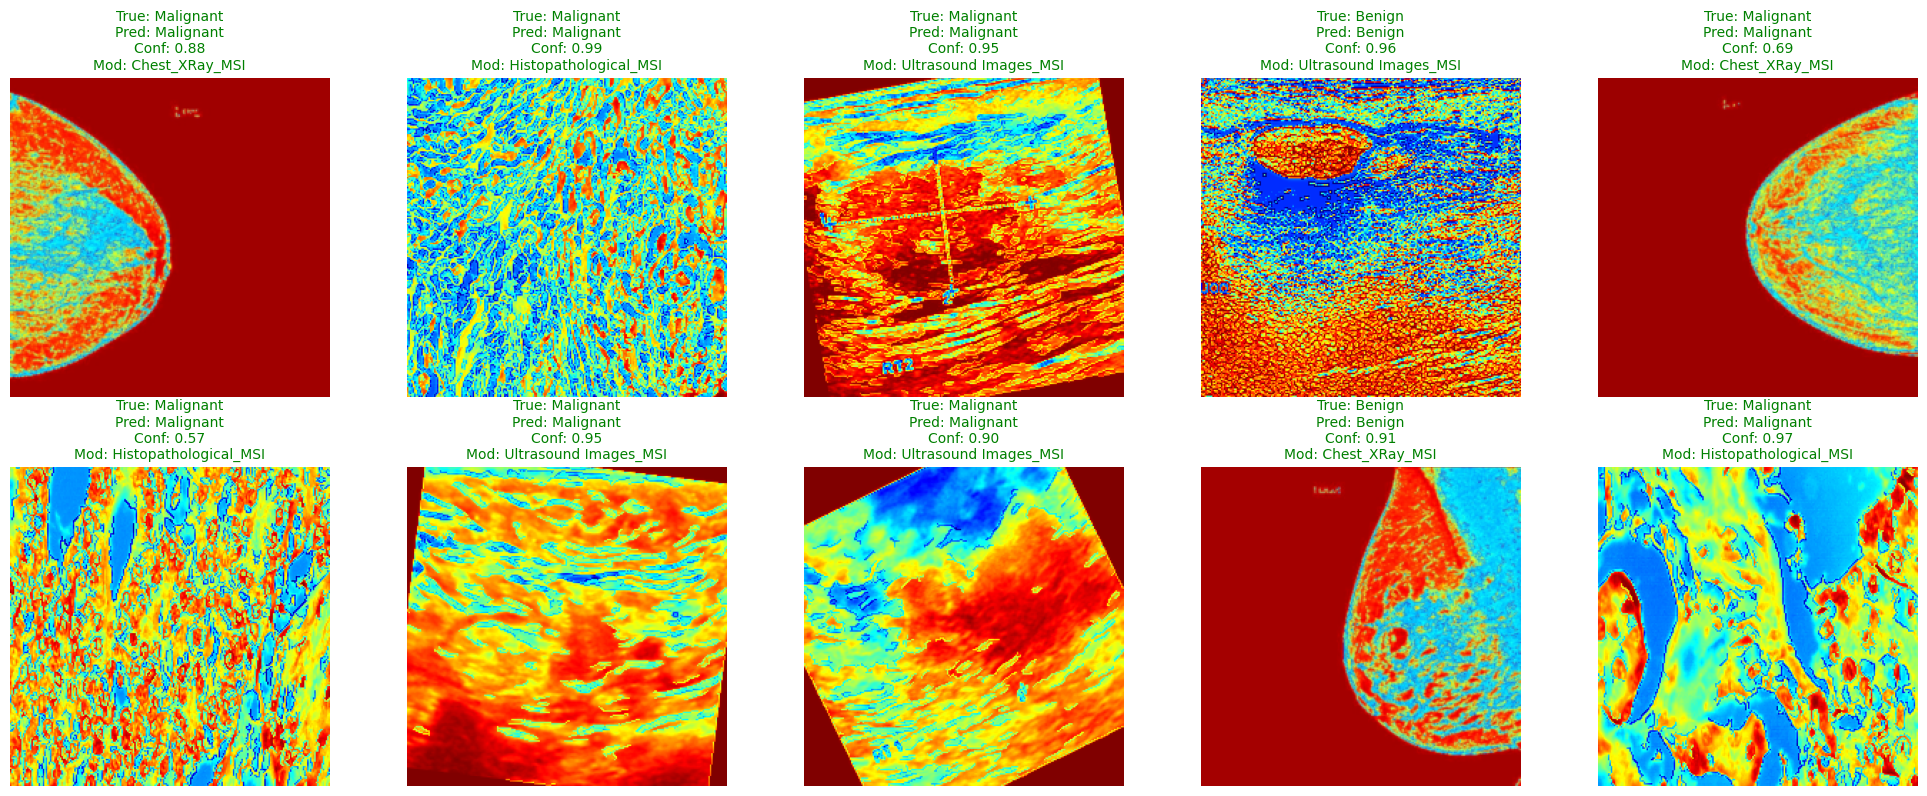


Dataset distribution analysis:
Dataset Analysis:
Class distribution:
  Benign: 152 samples (50.0%)
  Malignant: 152 samples (50.0%)

Modality distribution:
  Chest_XRay_MSI: 100 samples (32.9%)
  Histopathological_MSI: 124 samples (40.8%)
  Ultrasound Images_MSI: 80 samples (26.3%)

Class-Modality Cross-tabulation:
  Chest_XRay_MSI:
    Benign: 50
    Malignant: 50
  Histopathological_MSI:
    Benign: 62
    Malignant: 62
  Ultrasound Images_MSI:
    Benign: 40
    Malignant: 40
Dataset distribution plot saved to: results/dataset_distribution.png


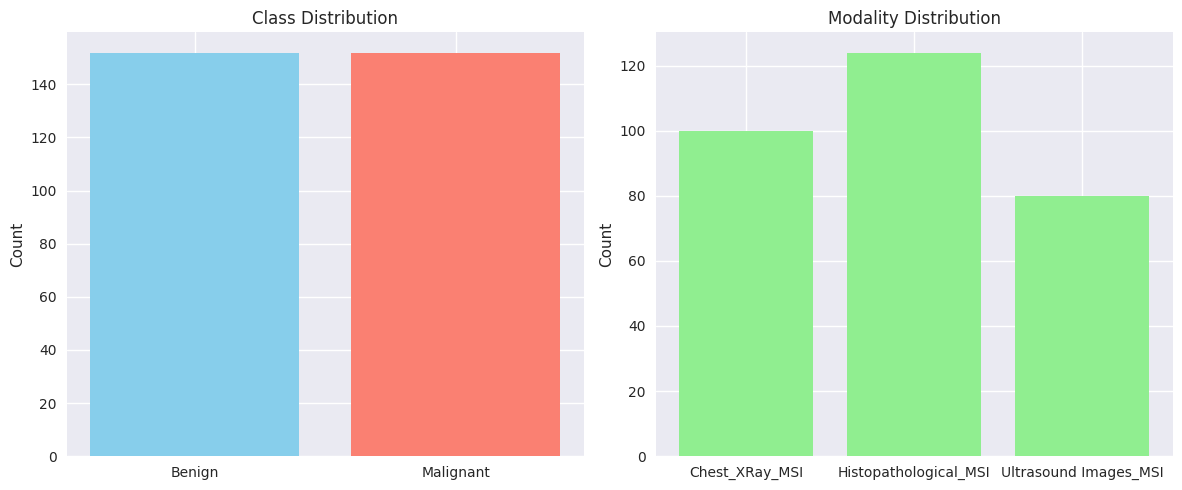


Running cross-validation...
Starting 3-fold cross-validation...
Loaded Ultrasound Images_MSI: {'benign': 40, 'malignant': 40}
Loaded Histopathological_MSI: {'benign': 62, 'malignant': 62}
Loaded Chest_XRay_MSI: {'Malignant': 50, 'Normal': 50}
Total samples: 304
Class distribution: [152 152]

Fold 1/3
------------------------------

Epoch [1/20]
--------------------------------------------------
Batch [0/13], Loss: 0.8464
Train Loss: 0.7242, Train Acc: 0.5149
Val Loss: 0.6916, Val Acc: 0.5686, Val AUC: 0.5967
LR: 4.00e-05
New best model saved with AUC: 0.5967

Epoch [2/20]
--------------------------------------------------
Batch [0/13], Loss: 0.7798
Train Loss: 0.6233, Train Acc: 0.6733
Val Loss: 0.6605, Val Acc: 0.6176, Val AUC: 0.6920
LR: 4.00e-05
New best model saved with AUC: 0.6920

Epoch [3/20]
--------------------------------------------------
Batch [0/13], Loss: 0.6736
Train Loss: 0.5991, Train Acc: 0.6980
Val Loss: 0.6352, Val Acc: 0.6863, Val AUC: 0.7347
LR: 4.00e-05
New best

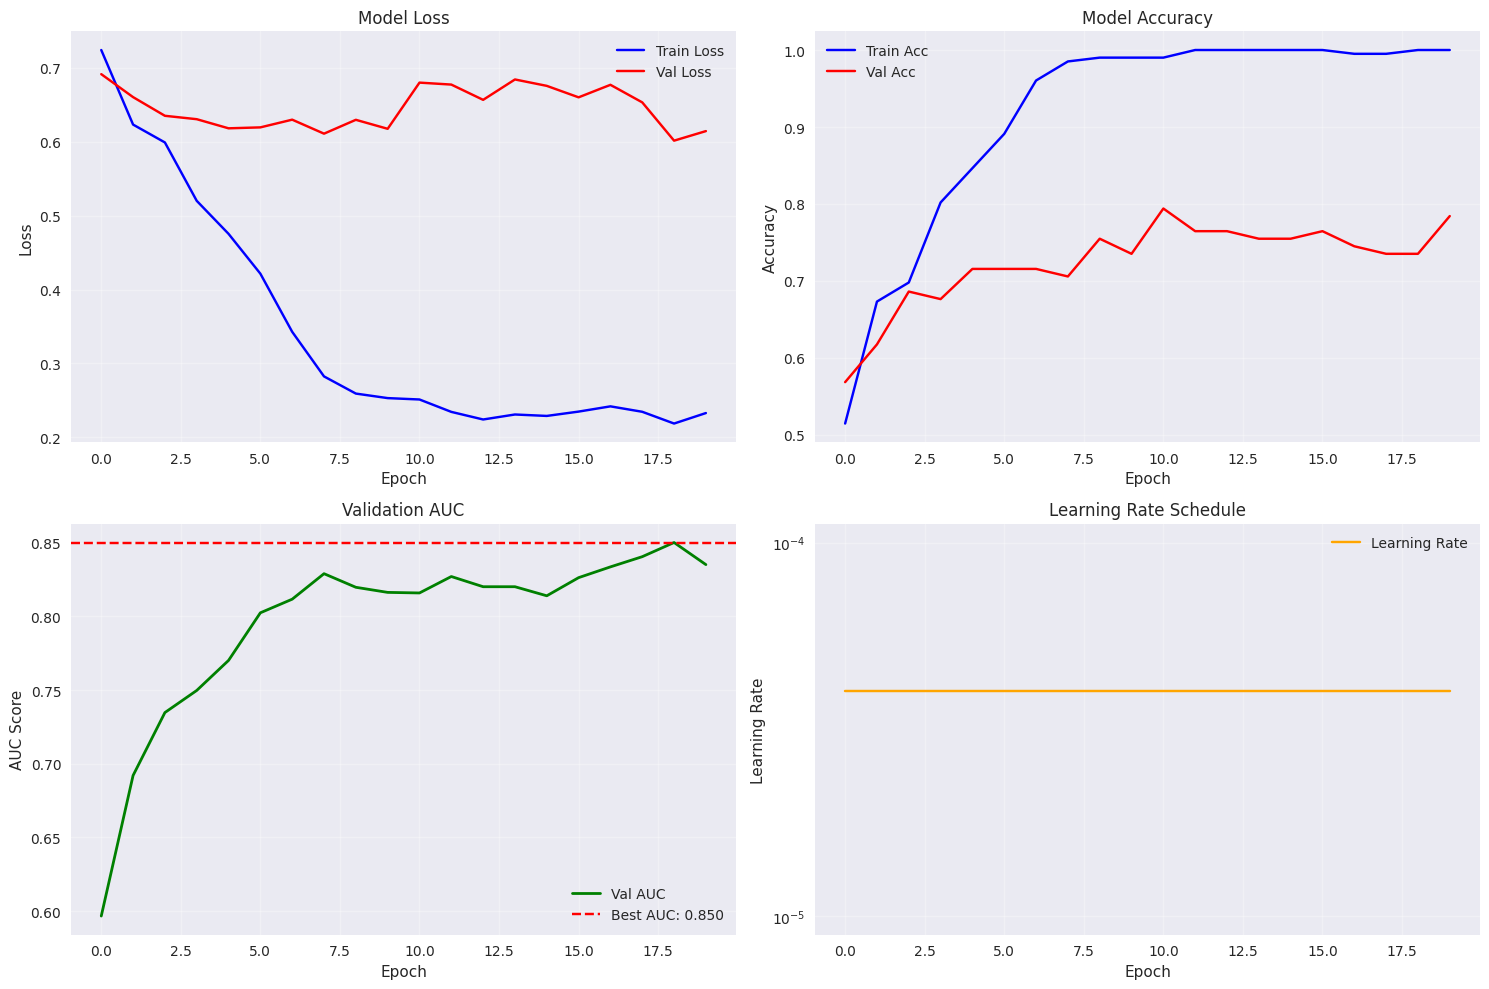

Fold 1 Results: Acc=0.784, AUC=0.835

Fold 2/3
------------------------------

Epoch [1/20]
--------------------------------------------------
Batch [0/13], Loss: 0.8581
Train Loss: 0.7263, Train Acc: 0.5074
Val Loss: 0.6976, Val Acc: 0.5545, Val AUC: 0.5631
LR: 4.00e-05
New best model saved with AUC: 0.5631

Epoch [2/20]
--------------------------------------------------
Batch [0/13], Loss: 0.7281
Train Loss: 0.6412, Train Acc: 0.6355
Val Loss: 0.6693, Val Acc: 0.6634, Val AUC: 0.6847
LR: 4.00e-05
New best model saved with AUC: 0.6847

Epoch [3/20]
--------------------------------------------------
Batch [0/13], Loss: 0.5725
Train Loss: 0.5930, Train Acc: 0.7192
Val Loss: 0.6363, Val Acc: 0.6535, Val AUC: 0.7427
LR: 4.00e-05
New best model saved with AUC: 0.7427

Epoch [4/20]
--------------------------------------------------
Batch [0/13], Loss: 0.5989
Train Loss: 0.5122, Train Acc: 0.8325
Val Loss: 0.6252, Val Acc: 0.6535, Val AUC: 0.7557
LR: 4.00e-05
New best model saved with AUC: 0

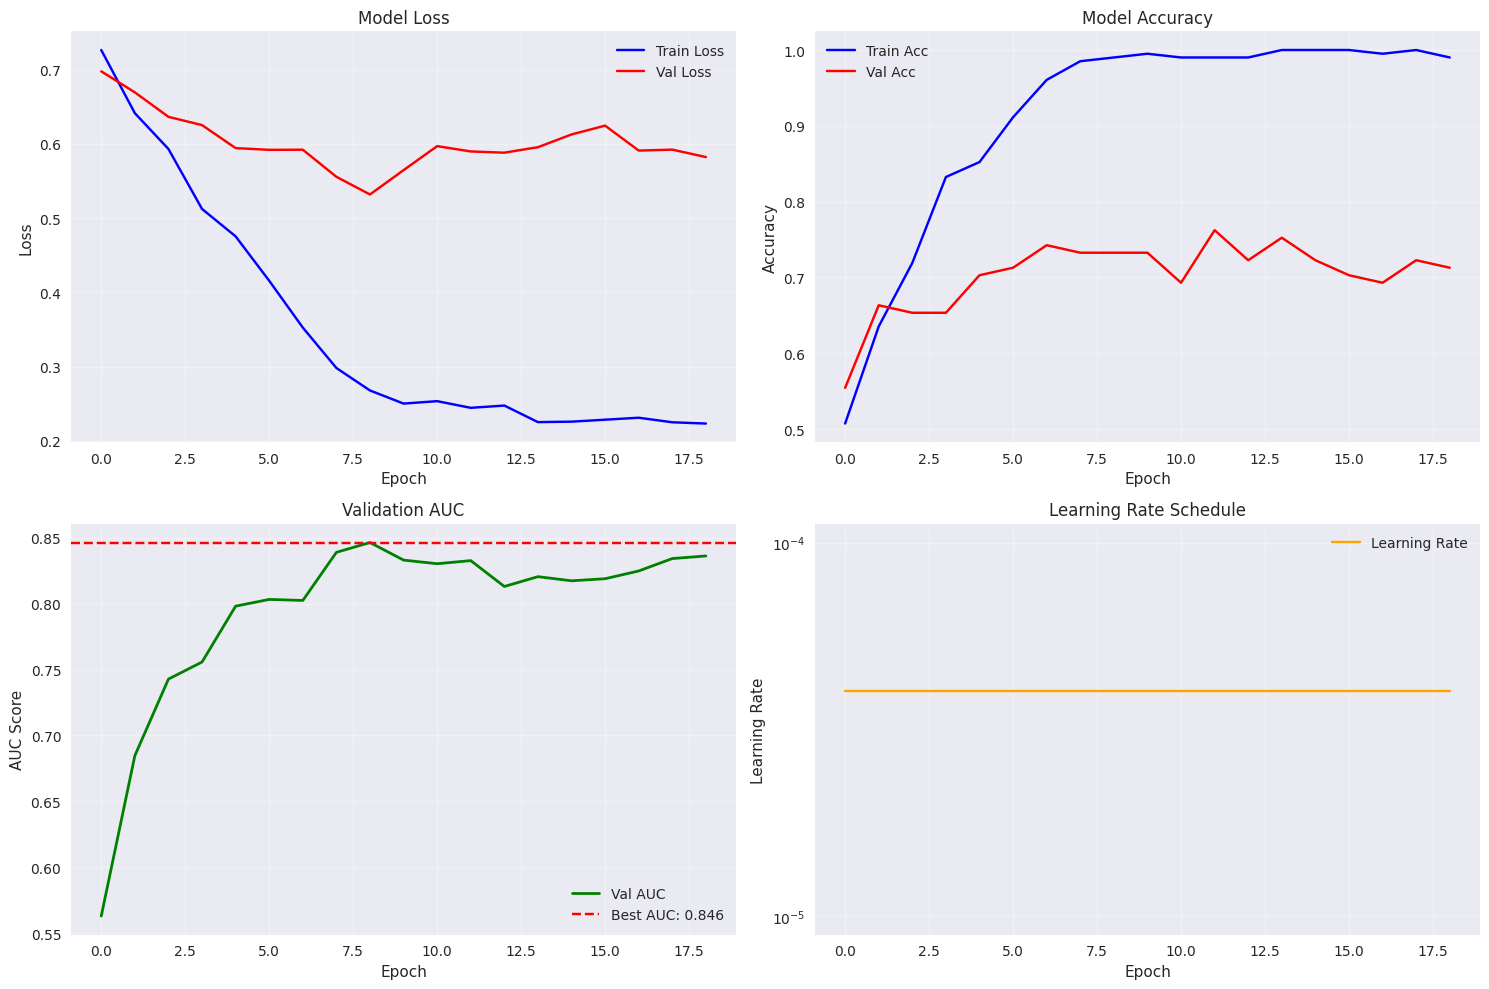

Fold 2 Results: Acc=0.713, AUC=0.836

Fold 3/3
------------------------------

Epoch [1/20]
--------------------------------------------------
Batch [0/13], Loss: 0.6304
Train Loss: 0.7228, Train Acc: 0.5517
Val Loss: 0.6961, Val Acc: 0.5248, Val AUC: 0.5580
LR: 4.00e-05
New best model saved with AUC: 0.5580

Epoch [2/20]
--------------------------------------------------
Batch [0/13], Loss: 0.7103
Train Loss: 0.6603, Train Acc: 0.5961
Val Loss: 0.7006, Val Acc: 0.5842, Val AUC: 0.6039
LR: 4.00e-05
New best model saved with AUC: 0.6039

Epoch [3/20]
--------------------------------------------------
Batch [0/13], Loss: 0.6948
Train Loss: 0.5828, Train Acc: 0.7094
Val Loss: 0.6909, Val Acc: 0.6436, Val AUC: 0.6467
LR: 4.00e-05
New best model saved with AUC: 0.6467

Epoch [4/20]
--------------------------------------------------
Batch [0/13], Loss: 0.6278
Train Loss: 0.5302, Train Acc: 0.7783
Val Loss: 0.6845, Val Acc: 0.6238, Val AUC: 0.6643
LR: 4.00e-05
New best model saved with AUC: 0

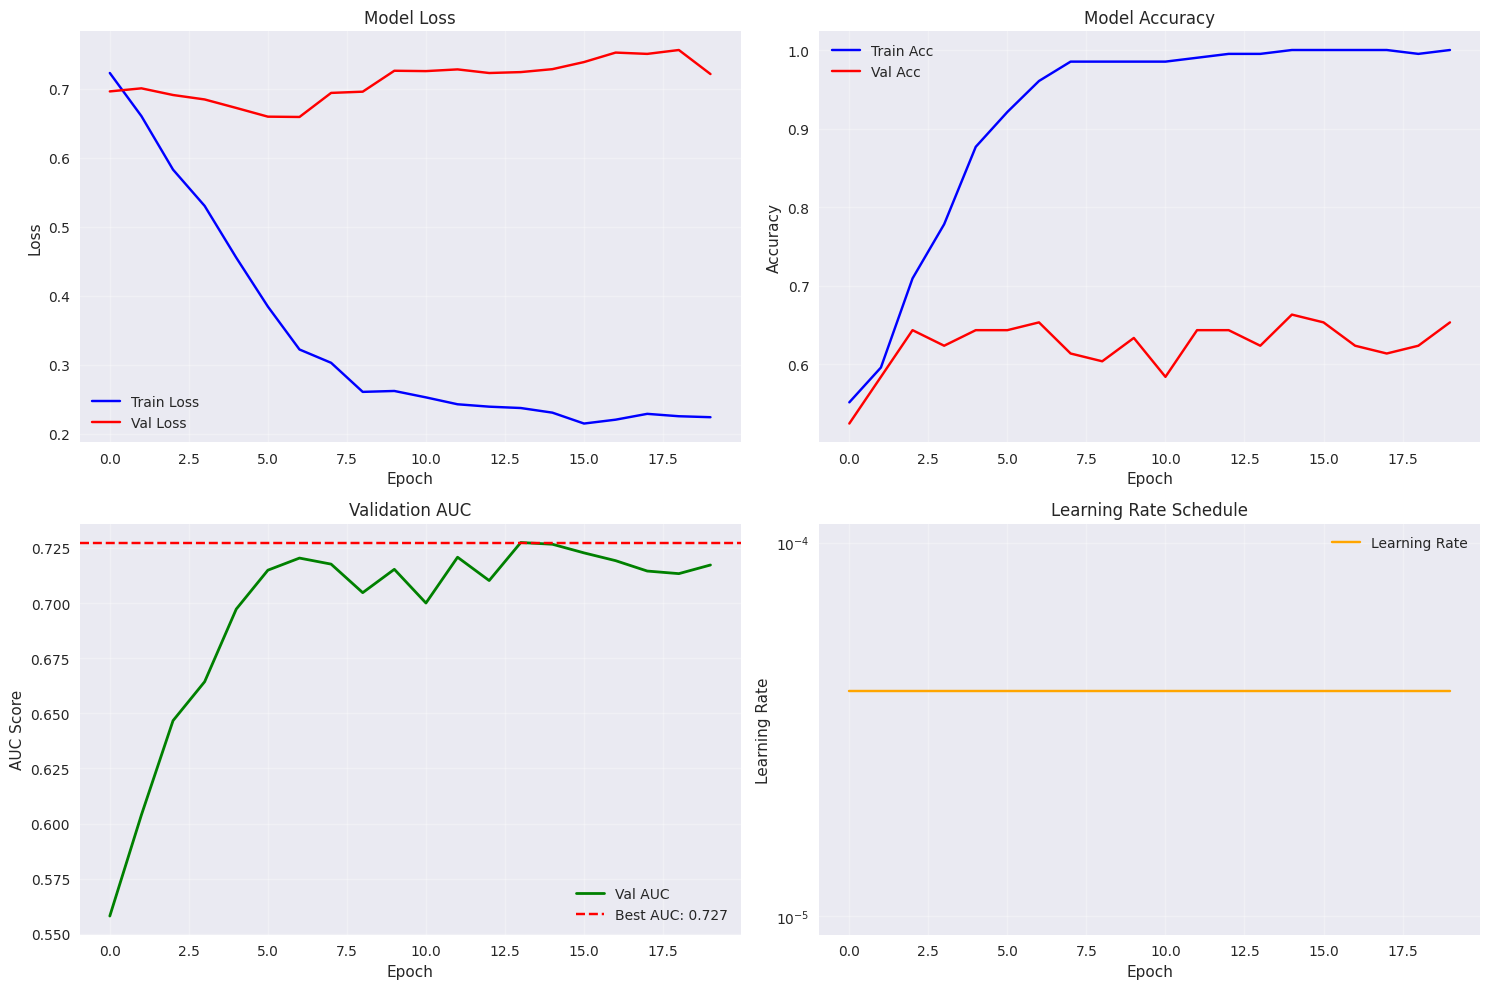

Fold 3 Results: Acc=0.653, AUC=0.717

Cross-Validation Summary:
ACCURACY: 0.717 ± 0.066
AUC: 0.796 ± 0.068
CV summary saved to: results/cross_validation_summary.csv


In [81]:
# Additional analysis if training was successful
if model is not None:
    print("\n" + "="*60)
    print("ADDITIONAL ANALYSIS")
    print("="*60)
    
    # Analyze some predictions visually
    try:
        transforms_obj = Transforms(config.IMAGE_SIZE)
        val_dataset = MultiModalDataset(config.VAL_PATHS, transform=transforms_obj.val_transform)
        val_loader = DataLoader(val_dataset, batch_size=8, shuffle=True)
        
        print("\nVisualizing model predictions...")
        analyze_model_predictions(model, val_loader, config.DEVICE, num_samples=10, save_path=os.path.join(RESULTS_DIR, "sample_predictions.png"))
        
        print("\nDataset distribution analysis:")
        analyze_dataset_distribution(val_dataset, save_dir=RESULTS_DIR)
        
    except Exception as e:
        print(f"Error in additional analysis: {e}")
    
    # Optionally run cross-validation (commented out by default due to time requirements)
    print("\nRunning cross-validation...")
    cv_results = cross_validation_evaluation(config, k_folds=3, save_dir=RESULTS_DIR)